In [2]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
df =  pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Estimamos la distribución de las variables

<Axes: >

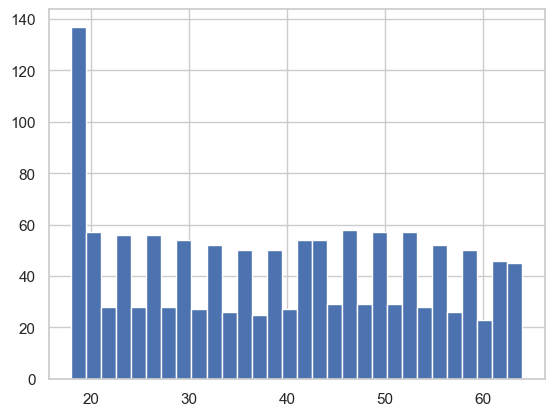

In [4]:
df.age.hist(bins=30)

In [5]:
print(df['age'].max()) #edad mayor registrada
print(df['age'].min()) #edad menor registrada

64
18


<Axes: >

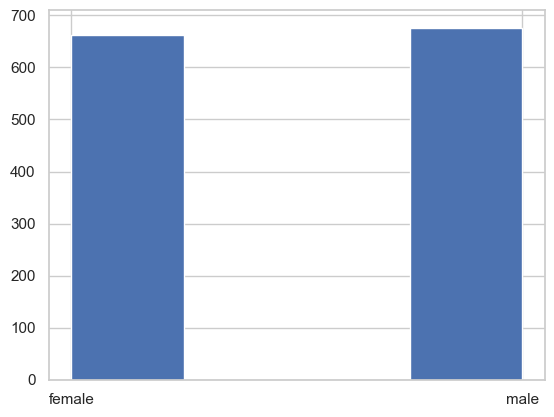

In [6]:
df.sex.hist(bins=4)

Visualizamos la variable predictora

<Axes: >

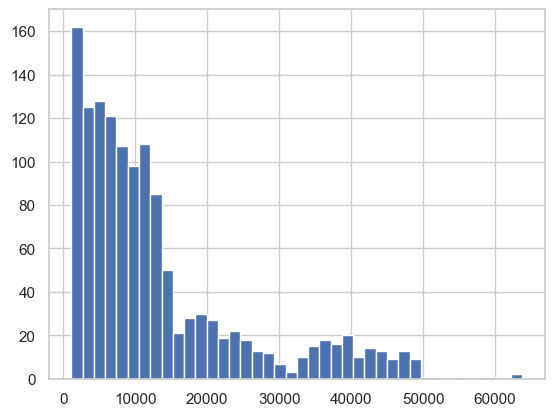

In [7]:
df.charges.hist(bins=40)

In [8]:
#tratamos de determinar cuantos registros hay mayores a 50000
df[df.charges>50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


Se encuentran muy pocos registros mayoer a 50000, podrian considerarse valores atipicos, por eso sobreescribiremos nuestra variable df sin incluir valores mayores a 50000

In [9]:
df = df[df.charges<50000]

Correlación de variables

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


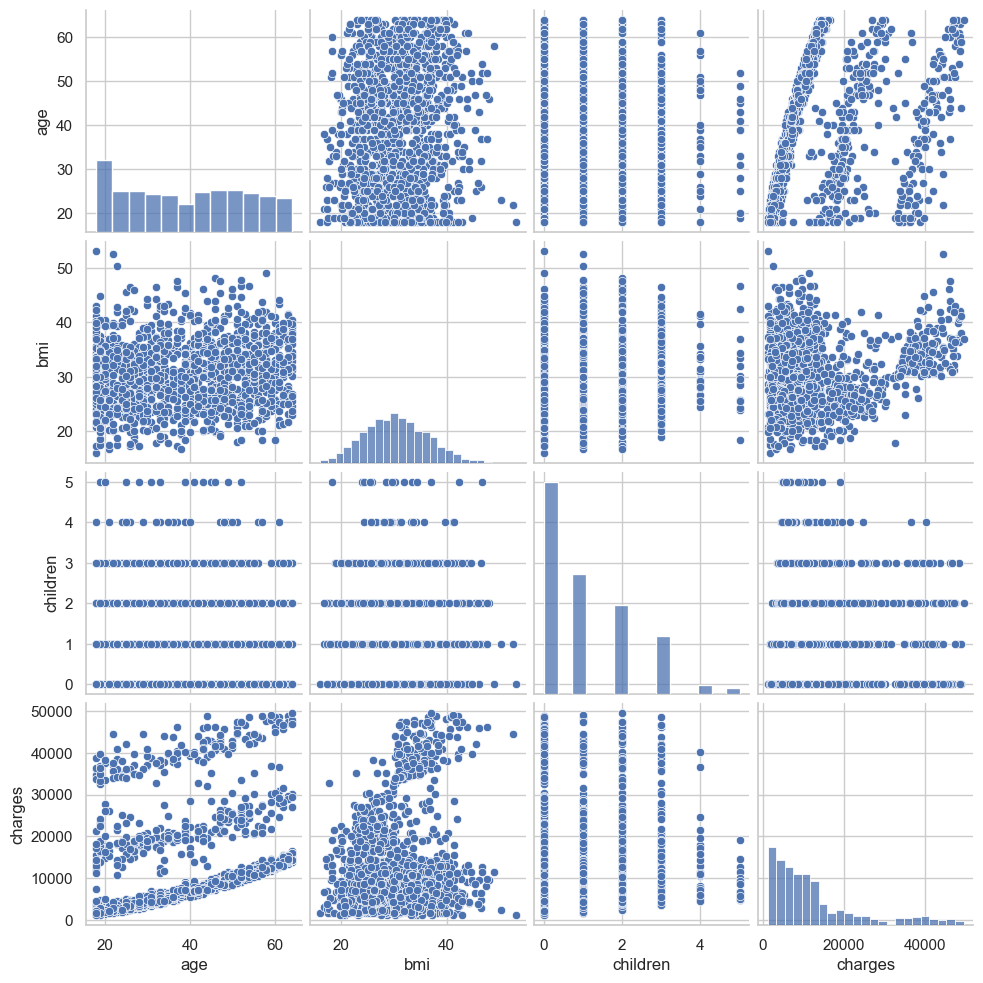

In [10]:
import matplotlib.pyplot as plt
sns.pairplot(df, height=2.5)
plt.show()

<Axes: >

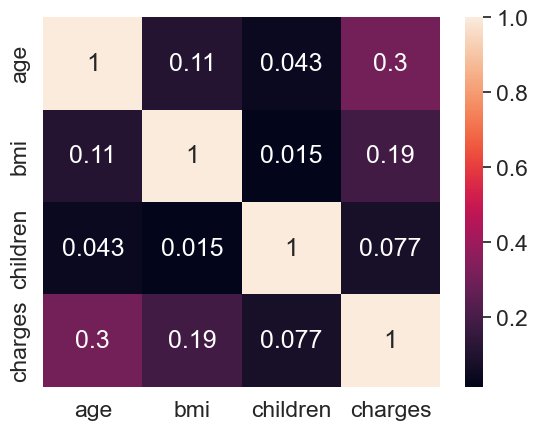

In [11]:
#ahora lo haremos con un mapa de calor

import numpy  as np

# trabajaremos con las variables numericas

numeric_cols = ['age', 'bmi', 'children', 'charges']
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, yticklabels=numeric_cols, xticklabels=numeric_cols)

Trabajaremos las demas variables las cuales son categoricas (sexo, fumador, región), para poder incluirlas en el modelos utilizaremos utilizamoremos la función get:dummies de pandas

In [12]:
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


Crearemos el Modelos

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  LinearRegression
from sklearn.model_selection import train_test_split


In [17]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df[X_cols].values
y = df[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

y_pred.shape

(333, 1)

Funciones Métricas

In [18]:
import sklearn.metrics as metrics

#utilizaremos error cuadrático medio y evaluaremos la columna de prueba contra los valores predichos
mse = metrics.mean_squared_error(y_test, y_pred)

#tamben evaluaremos con r cuadrado
r2 = metrics.r2_score(y_test, y_pred)

print('r2',     r2.round(4))
print('mse', mse.round(4))

r2 0.7768
mse 0.2154


Mostramos un resumen general de los resultados

In [19]:
from regressors import stats

model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)
y_test = y_test.reshape(-1)
print('==========Sumary===========')
stats.sumary(model, X_test, y_test, X_cols)

Calculamos los  valores residuales

Los residuos son las diferencias entre los valores observados reales (y_test) y las predicciones del modelo (y_pred).

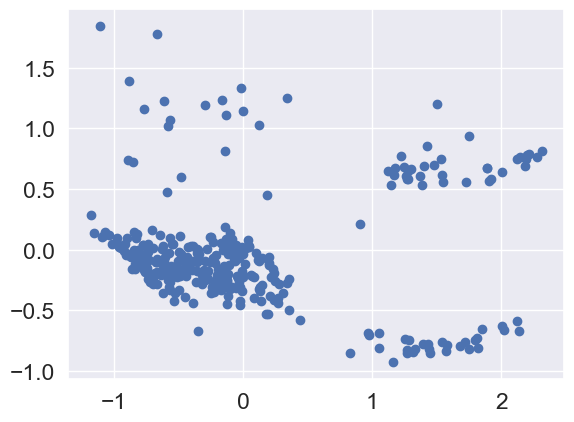

In [20]:
residuals = np.subtract(y_test, y_pred)

# Graficamos la prediccion con respecto a los valores del  residuo

plt.scatter(y_pred, residuals)
plt.show()

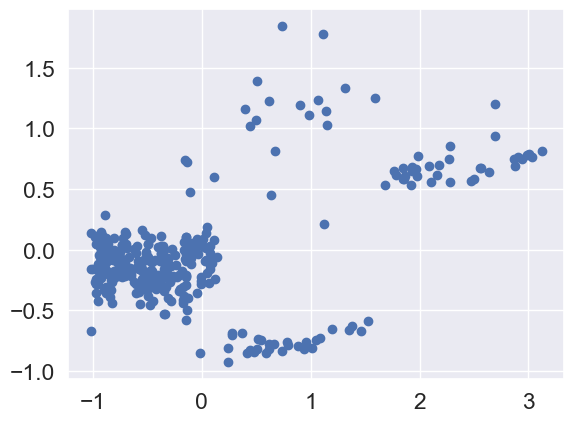

In [21]:
plt.scatter(y_test, residuals)
plt.show()

Los resultados anteriores son buenos, pero se pueden mejorar

Segundo Modelo

In [28]:
df_second = df.copy()

#se crearan nuevas variables
df_second['age2'] = df_second.age**2
df_second['sobrepeso'] = (df_second.bmi>=30).astype(int)
df_second['sobrepeso*fumador'] = df_second.sobrepeso * df_second.smoker_yes

In [29]:
df_second

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age2,sobrepeso,sobrepeso*fumador
0,19,27.900,0,16884.92400,False,True,False,False,True,361,0,0
1,18,33.770,1,1725.55230,True,False,False,True,False,324,1,0
2,28,33.000,3,4449.46200,True,False,False,True,False,784,1,0
3,33,22.705,0,21984.47061,True,False,True,False,False,1089,0,0
4,32,28.880,0,3866.85520,True,False,True,False,False,1024,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False,2500,1,0
1334,18,31.920,0,2205.98080,False,False,False,False,False,324,1,0
1335,18,36.850,0,1629.83350,False,False,False,True,False,324,1,0
1336,21,25.800,0,2007.94500,False,False,False,False,True,441,0,0


In [36]:
X_cols = list(set(df.columns)-set(['charges']))
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)


In [37]:
#utilizaremos error cuadrático medio y evaluaremos la columna de prueba contra los valores predichos
mse = metrics.mean_squared_error(y_test, y_pred)

#tamben evaluaremos con r cuadrado
r2 = metrics.r2_score(y_test, y_pred)

print('r2',     r2.round(4))
print('mse', mse.round(4))

r2 0.755
mse 0.2598


In [ ]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)
y_test = y_test.reshape(-1)
print('==========Sumary===========')
stats.sumary(model, X_test, y_test, X_cols)

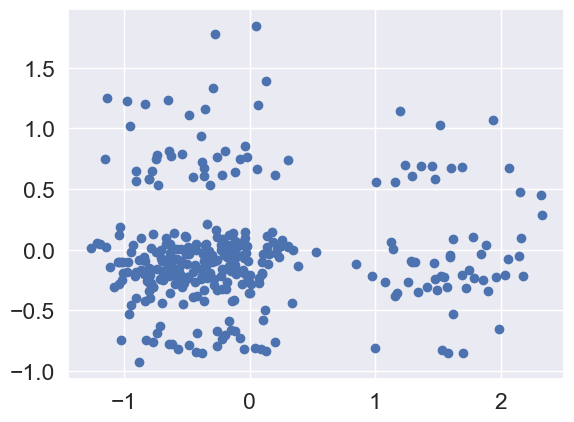

In [27]:
    plt.scatter(y_pred, residuals)
    plt.show()

Se oberva una mejor predicción 

vamos a evaluar que columnas nos ayudan mas en el modelo

In [40]:
X_cols = ['sobrepeso*fumador', 'smoker_yes', 'age2', 'children', ]
y_col = ['charges']

X = df_second[X_cols].values
y = df_second[y_col].values

X_train, X_test, y_train, y_test = train_test_split(X,y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

model = LinearRegression(fit_intercept=False)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [43]:
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print('r2',     r2.round(4))
print('mse', mse.round(4))

r2 0.8606
mse 0.1487


In [ ]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)
y_test = y_test.reshape(-1)
print('==========Sumary===========')
stats.sumary(model, X_test, y_test, X_cols)

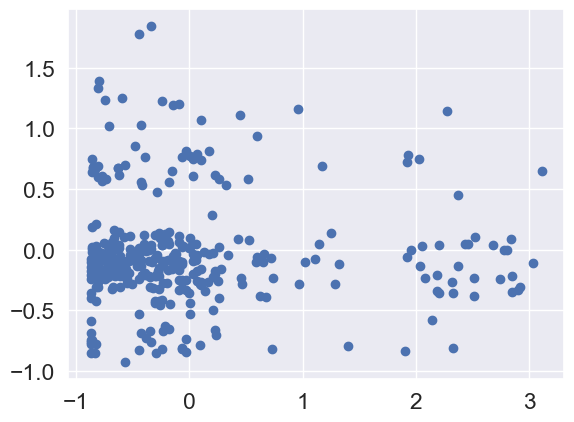

In [44]:
plt.scatter(y_pred, residuals)
plt.show()

se observa cerca de la linea de cero los puntos mas ajustados, es decir , mejoramos la predicción usando menos variables.